In [1]:
import multiprocessing as mp
import typing

In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import scipy as sp
import scipy.stats as stats
import sklearn.utils

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

From Wikipedia:
> In the mathematics of shuffling playing cards, the Gilbert–Shannon–Reeds model is a probability distribution on riffle shuffle permutations that has been reported to be a good match for experimentally observed outcomes of human shuffling, and that forms the basis for a recommendation that a deck of cards should be riffled seven times in order to thoroughly randomize it. ... The deck of cards is cut into two packets... [t]hen, one card at a time is repeatedly moved from the bottom of one of the packets to the top of the shuffled deck.

Here we implement the Gilbert–Shannon–Reeds model, and verify this recommendation of seven shuffles.

Note that the functions below have `doctest` examples.
To test the functions, just run `pytest` in the top level of the repository.

First, define a function to determine how many cards to split into our right hand.

In [4]:
def get_random_number_for_right_deck(n: int, seed: int=None, ) -> int:
    """
    Return the number of cards to split into the right sub-deck.

    :param n: one above the highest number that could be returned by this
              function.
    :param seed: optional seed for the random number generator to enable
                 deterministic behavior.
    :return: a random integer (between 1 and n-1) that represents the
             desired number of cards.

    Examples:

    >>> get_random_number_for_right_deck(n=5, seed=0, )
    1
    """
    random = sklearn.utils.check_random_state(seed=seed, )
    
    return num_cards // 2
    return random.randint(low=1, high=n, )

Next, define a function to determine which hand to drop a card from.

In [5]:
def should_drop_from_right_deck(n_left: int, n_right:int, seed: int=None, ) -> bool:
    """
    Determine whether we drop a card from the right or left sub-deck.
    
    Either `n_left` or `n_right` (or both) must be greater than zero.
    
    :param n_left: the number of cards in the left sub-deck.
    :param n_right: the number of cards in the right sub-deck.
    :param seed: optional seed for the random number generator to
                 enable deterministic behavior.
    :return: True if we should drop a card from the right sub-deck,
             False otherwise.
    
    Examples:

    >>> should_drop_from_right_deck(n_left=32, n_right=5, seed=0, )
    True

    >>> should_drop_from_right_deck(n_left=0, n_right=5, )
    True

    >>> should_drop_from_right_deck(n_left=7, n_right=0, )
    False

    >>> should_drop_from_right_deck(n_left=0, n_right=0, )
    Traceback (most recent call last):
    ...
    ValueError: Either `n_left` or `n_right` (or both) must be greater than zero.
    """
    if n_left > 0 and n_right > 0:
        random = sklearn.utils.check_random_state(seed=seed, )
        value = random.random_sample()
        card_diff = n_right - n_left
        if card_diff < -4:
            card_diff = -4
        if card_diff > 4:
            card_diff = 4
        probability = 0.5 + (card_diff * 0.1)
        boolean = (value <= probability)
        return boolean
    elif n_left == 0 and n_right > 0:
        # There are no more cards in the left sub-deck, only
        # the right sub-deck, so we drop from the right sub-deck.
        return True
    elif n_left > 0 and n_right == 0:
        # There are no more cards in the right sub-deck, only
        # the left sub-deck, so we drop from the left sub-deck.
        return False
    else:
        # There are no more cards in either sub-deck.
        raise ValueError ('Either `n_left` or `n_right` '\
                          '(or both) must be greater than zero.')

Now we can implement the 'Gilbert–Shannon–Reeds' shuffle.

In [6]:
def shuffle(deck: np.array, seed: int=None, ) -> np.array:
    """
    Shuffle the input 'deck' using the Gilbert–Shannon–Reeds method.

    :param seq: the input sequence of integers.
    :param seed: optional seed for the random number generator
                 to enable deterministic behavior.
    :return: A new deck containing shuffled integers from the
             input deck.

    Examples:

    >>> shuffle(deck=np.array([0, 7, 3, 8, 4, 9, ]), seed=0, )
    array([4, 8, 3, 7, 0, 9])
    """
    
    # First randomly divide the 'deck' into 'left' and 'right'
    # 'sub-decks'.
    num_cards_in_deck = len(deck)
    orig_num_cards_right_deck = get_random_number_for_right_deck(
        n=num_cards_in_deck,
        seed=seed,
    )

    # By definition of get_random_number_for_right_deck():
    n_right = orig_num_cards_right_deck
    
    n_left = num_cards_in_deck - orig_num_cards_right_deck
    
    shuffled_deck = np.empty(num_cards_in_deck, dtype=int)
    
    # We will drop a card n times.
    for index in range(num_cards_in_deck):
        drop_from_right_deck = should_drop_from_right_deck(
            n_left=n_left,
            n_right=n_right,
            seed=seed,
        )
        
        if drop_from_right_deck is True:
            # Drop from the bottom of right sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[n_right - 1]
            n_right = n_right - 1
        else:
            # Drop from the bottom of left sub-deck
            # onto the shuffled pile.
            shuffled_deck[index] = deck[
                orig_num_cards_right_deck + n_left - 1
            ]
            n_left = n_left - 1
    
    return shuffled_deck

Finally, we run some experiments to confirm the recommendation of seven shuffles for a deck of 52 cards.

In [7]:
num_cards = 52
max_num_shuffles = 20
num_decks = 10000

# Shuffling the cards using a uniform probability
# distribution results in the same expected frequency
# for each card in each deck position.
uniform_rel_freqs = np.full(
    shape=[num_cards, num_cards],
    fill_value=1./num_cards,
)

In [8]:
def calculate_differences(
    num_shuffles: int
    ) -> typing.Tuple[np.float64, np.float64, np.float64,]:
    """
    Calculate differences between observed and uniform distributions.
    
    :param The number of times to shuffle the deck each time.
    :return Three metrics for differences between the
            observed and uniform relative frequencies.
    """
    shuffled_decks = np.empty(shape=[num_decks, num_cards], )

    # First create a random deck.
    orig_deck = np.array(range(num_cards))
    np.random.shuffle(orig_deck)

    for i in range(num_decks):
        # Now shuffle this deck using the Gilbert–Shannon–Reeds method.
        new_deck = orig_deck
        for j in range(num_shuffles):
            new_deck = shuffle(new_deck)
        
        shuffled_decks[i] = new_deck

    # Calculate the relative frequencies of each card in each position.
    rel_freqs = np.empty(shape=[num_cards, num_cards], )

    for i in range(num_cards):
        col = shuffled_decks[:, i]
        
        # Make sure that each card appears at least once in this
        # position, by first adding the entire deck, and then
        # subtracting 1 from the total counts of each card in
        # this position.
        col = np.append(col, orig_deck)
        col_freqs = sp.stats.itemfreq(col)[:, 1]
        col_freqs = col_freqs - 1
        rel_freqs[i] = col_freqs / num_decks
    
    # Here I use three metrics for differences between the
    # observed and uniform relative frequencies:
    # * The sum of the squared element-wise differences,
    # * The relative information entropy, and
    # * The Kolmogorov-Smirnov statistic.
    sum_squared = np.sum(np.square(np.subtract(uniform_rel_freqs, rel_freqs)))
    entropy = stats.entropy(rel_freqs.flatten(), uniform_rel_freqs.flatten())
    kstest = stats.kstest(rel_freqs.flatten(), 'uniform').statistic
    
    return sum_squared, entropy, kstest

In [9]:
# Now run the experiment using all our CPUs!

with mp.Pool(mp.cpu_count() - 2) as p:
    results = p.map(calculate_differences, range(1, max_num_shuffles+1))
    results = np.array(results)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


In [10]:
sums_squared = results[:, 0]
entropies = results[:, 1]
kstests = results[:, 2]

The KS statistics are of most use here. You can see how the statistic approaches its maximum value around num_shuffles = 7.

In [11]:
fs = 14

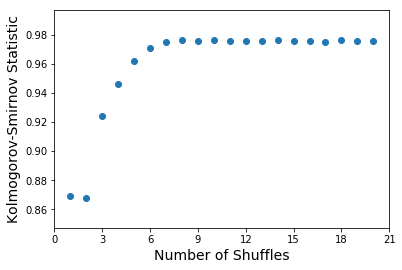

In [12]:
fig, ax = plt.subplots()
ax.scatter(range(1, max_num_shuffles + 1), kstests, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Kolmogorov-Smirnov Statistic', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();

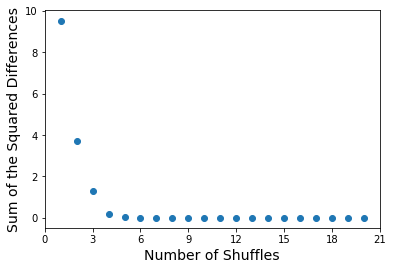

In [13]:
fig, ax = plt.subplots()
ax.scatter(range(1, max_num_shuffles + 1), sums_squared, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Sum of the Squared Differences', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();

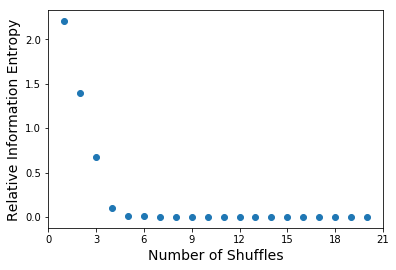

In [14]:
fig, ax = plt.subplots()
ax.scatter(range(1, max_num_shuffles + 1), entropies, );
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xlabel('Number of Shuffles', fontsize=fs, )
ax.set_ylabel('Relative Information Entropy', fontsize=fs, )
ax.set_xlim([0, max_num_shuffles + 1])
plt.show();